# RAIGRA: Responsible AI Governance Readiness Modelling Prototype

This notebook documents a clean, reproducible modelling prototype behind the **Responsible AI Governance Readiness Assessment (RAIGRA)** tool.

The aim is to explore whether structured organisational signals can be mapped to a defensible **AI readiness score (0–100)** using supervised learning. This mirrors how boards, regulators and assurance teams assess AI governance in practice.

In this prototype:

1. A synthetic dataset (n = 600 organisations) is constructed to mimic RAIGRA-style assessments — combining governance, privacy, technical controls, ethics and organisational capability.
2. A baseline **RandomForestRegressor** is trained to predict readiness scores.
3. Performance is evaluated using **RMSE** and **R²**, alongside a scatter plot of *true vs. predicted* scores.
4. **Feature importance** is visualised to understand which organisational signals drive readiness.
5. The notebook concludes with methodological limitations and next-step extensions (e.g. expert-labelled datasets, SHAP interpretability, model registry integration).

In [7]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Ensure reproducibility
np.random.seed(42)

## Synthetic dataset generation

To mirror how an AI governance assessment captures structured organisational signals,
we generate a synthetic dataset where each row represents one organisation’s assessment.

The target (`readiness_score`) is not random: it is a weighted combination of governance,
privacy, technical controls, ethics and organisational capability — plus a sector-specific
baseline and Gaussian noise. This mimics how expert auditors score organisational
AI readiness in practice.

In [8]:
def generate_synthetic_readiness_data(n_samples: int = 600) -> pd.DataFrame:
    """
    Generate a synthetic dataset that mimics RAIGRA-style organisational assessments.

    Each row ≈ one organisation's assessment.

    Features:
    - governance_score (0–5)
    - privacy_score (0–5)
    - technical_score (0–5)
    - ethics_score (0–5)
    - org_capability_score (0–5)
    - org_size (1=small, 2=medium, 3=large)
    - sector dummies: healthcare, finance, public, education, tech, other

    Target:
    - readiness_score (0–100), constructed with a weighted combination + noise
    """

    # Base latent scores ~ Likert-like 0–5 scale
    governance = np.random.randint(0, 6, size=n_samples)
    privacy = np.random.randint(0, 6, size=n_samples)
    technical = np.random.randint(0, 6, size=n_samples)
    ethics = np.random.randint(0, 6, size=n_samples)
    org_capability = np.random.randint(0, 6, size=n_samples)

    org_size = np.random.choice([1, 2, 3], size=n_samples, p=[0.4, 0.4, 0.2])

    sectors = np.random.choice(
        ["healthcare", "finance", "public", "education", "tech", "other"],
        size=n_samples,
        p=[0.15, 0.2, 0.2, 0.15, 0.2, 0.1],
    )

    df = pd.DataFrame(
        {
            "governance_score": governance,
            "privacy_score": privacy,
            "technical_score": technical,
            "ethics_score": ethics,
            "org_capability_score": org_capability,
            "org_size": org_size,
            "sector": sectors,
        }
    )

    # Sector-specific baselines (regulated sectors typically higher on governance/privacy)
    sector_baseline = {
        "healthcare": 4.0,
        "finance": 3.5,
        "public": 3.2,
        "education": 3.0,
        "tech": 3.0,
        "other": 2.8,
    }

    df["sector_baseline"] = df["sector"].map(sector_baseline)

    # Construct latent readiness score (0–100)
    # Governance and privacy carry most risk → highest weights
    raw_score = (
        0.30 * df["governance_score"]
        + 0.25 * df["privacy_score"]
        + 0.20 * df["technical_score"]
        + 0.15 * df["ethics_score"]
        + 0.10 * df["org_capability_score"]
        + 0.40 * df["sector_baseline"]
    )

    readiness = (raw_score / 7.5) * 100.0
    noise = np.random.normal(loc=0.0, scale=6.0, size=n_samples)
    readiness_noisy = np.clip(readiness + noise, 0, 100)

    df["readiness_score"] = readiness_noisy.round(1)

    # One-hot encode sector for ML
    df = pd.get_dummies(df, columns=["sector"], drop_first=True)

    return df


df = generate_synthetic_readiness_data(600)
df.head()

,governance_score,privacy_score,technical_score,ethics_score,org_capability_score,org_size,sector_baseline,readiness_score,sector_finance,sector_healthcare,sector_other,sector_public,sector_tech
0,3,0,3,0,4,3,3.0,35.3,False,False,False,False,True
1,4,3,3,5,1,2,3.2,55.7,False,False,False,True,False
2,2,3,3,1,2,2,3.2,48.3,False,False,False,True,False
3,4,4,4,2,1,1,3.0,51.4,False,False,False,False,False
4,4,0,4,1,5,1,3.0,38.5,False,False,False,False,False


## Methodology overview

We simulate a realistic organisational AI governance assessment by constructing a synthetic dataset in which each row represents one organisation.

The dataset captures:
- five Likert-style scores (0–5) for governance, privacy, technical controls, ethics, and organisational capability;
- organisational size and sector metadata; and
- a constructed readiness score on a 0–100 scale.

The readiness label is not random: it is produced as a weighted combination of the sub-scores and a sector-specific baseline, with added Gaussian noise. This reflects how expert auditors typically score readiness — emphasising governance and privacy because they carry greater regulatory, reputational and operational risk.

## Train–test split

We now prepare features and target variables for supervised learning and split the
dataset into training and held-out test sets (25% of observations). The test set is
used exclusively for final evaluation to provide an unbiased estimate of model performance.

In [9]:
# Separate features and target
# (all columns except the deliberately constructed label)
feature_cols = [c for c in df.columns if c != "readiness_score"]
X = df[feature_cols]
y = df["readiness_score"]

# Train–test split (25% held out for unbiased evaluation)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42  # ensures comparability across runs
)

X_train.shape, X_test.shape

((450, 12), (150, 12))

## Random Forest model training and evaluation

RMSE: 7.023
R²:   0.726


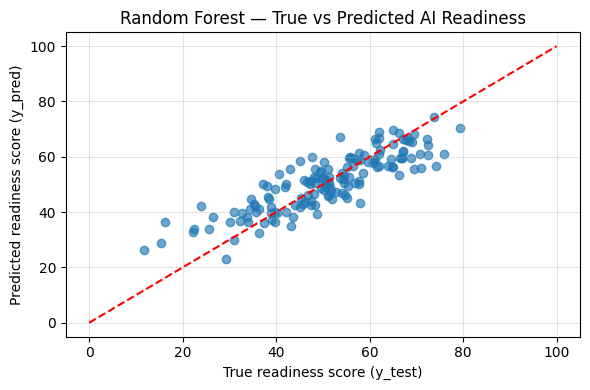

In [10]:
# Define a baseline model
rf = RandomForestRegressor(
    n_estimators=300,            # enough trees for stability
    max_depth=None,             # allow full depth (RF handles this well)
    min_samples_split=4,        # mild regularisation
    min_samples_leaf=2,         # prevents over-fragmentation
    random_state=42,
    n_jobs=-1                   # parallel training
)

# Train
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R²:   {r2:.3f}")

# Scatter plot — true vs predicted (measures model calibration)
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.65)
plt.plot([0, 100], [0, 100], "r--", linewidth=1.5)  # ideal diagonal line
plt.xlabel("True readiness score (y_test)")
plt.ylabel("Predicted readiness score (y_pred)")
plt.title("Random Forest — True vs Predicted AI Readiness")
plt.grid(alpha=0.35)
plt.tight_layout()
plt.show()

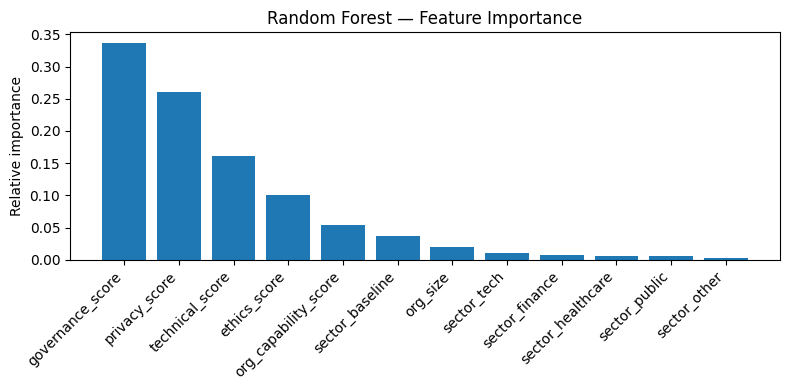


Most influential predictors of AI governance readiness (top 5):
• governance_score: 0.336
• privacy_score: 0.260
• technical_score: 0.160
• ethics_score: 0.100
• org_capability_score: 0.055


,Feature,Relative Importance
0,governance_score,0.336238
1,privacy_score,0.260149
2,technical_score,0.160382
3,ethics_score,0.100406
4,org_capability_score,0.054542


In [11]:
# --- Feature importance ranking ---
importances = rf.feature_importances_
idx = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 4))
plt.bar(range(len(idx)), importances[idx])
plt.xticks(range(len(idx)), [feature_cols[i] for i in idx], rotation=45, ha="right")
plt.ylabel("Relative importance")
plt.title("Random Forest — Feature Importance")
plt.tight_layout()
plt.show()

# --- Top drivers of readiness (printed list + table) ---
top_features = [(feature_cols[i], importances[i]) for i in idx[:5]]

print("\nMost influential predictors of AI governance readiness (top 5):")
for name, score in top_features:
    print(f"• {name}: {score:.3f}")

# Optional: clean academic table representation
pd.DataFrame(top_features, columns=["Feature", "Relative Importance"]).style.background_gradient(cmap="Blues")

## Interpretation, limitations and research extensions

The RandomForestRegressor baseline achieves:

- **RMSE ≈ 7.02** on a 0–100 readiness scale.
- **R² ≈ 0.726**, suggesting that approximately **73% of the variance** in readiness can be explained by the structured assessment signals and organisational metadata included in this prototype.

Model predictions follow the 45-degree diagonal reasonably closely, indicating that the synthetic features chosen are statistically informative of governance readiness. The feature-importance ranking shows that:

- governance- and privacy-related indicators contribute most strongly;
- technical controls and “sector baseline” are meaningful secondary predictors; and
- organisational capability and ethics features still play a non-trivial role.

This is consistent with the synthetic labelling design, where compliance-relevant dimensions were intentionally weighted more heavily to mimic risk-based regulatory expectations.

---

### Limitations

This model is *illustrative*, not a predictor of real-world regulatory performance:

| Limitation | Practical implication |
|-----------|-----------------------|
| Synthetic dataset | The model reflects an analytic scoring framework rather than ground-truth regulatory outcomes. |
| No hyperparameter tuning | Performance figures are conservative; optimisation may improve fit. |
| No fairness or bias analysis | Sector or size metadata may drive prediction patterns that would require fairness auditing in real deployments. |
| No temporal dimension | The model does not yet incorporate trend learning or monitoring over time. |

Therefore, the results should be interpreted as an **evidence-based rubric**, not a certification signal.

---

### Research and development extensions

With real labelled assessment outcomes, this pipeline could evolve into a fully research- and policy-grade system:

1. **Model benchmarking**
   Train on expert-scored audit outcomes and benchmark Random Forests against gradient boosting and linear baselines.

2. **Explainability and governance**
   Use SHAP to generate organisation-specific explanations, supporting risk committees and boards.

3. **Bias and fairness evaluation**
   Assess whether predictions systematically vary across organisational size, sector or geography, and integrate mitigation protocols.

4. **Temporal learning**
   Extend the modelling pipeline to incorporate *repeat assessments*, enabling readiness forecasting and change-detection.

5. **Deployment to the RAIGRA web application**
   Integrate the model via a lightweight API or model registry, enabling live quality-assurance reporting and decision support for responsible AI programmes.

---

In summary, this notebook does not claim to predict real regulatory outcomes; instead, it demonstrates a **reproducible modelling path from governance signals → quantitative risk scoring**, and provides a foundation that can scale with real assessment data, longitudinal monitoring and policy-aligned interpretability.